In [45]:
# Makes File Handling Easier
import os

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Image datasets and image manipulation
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard.writer import SummaryWriter

In [46]:
# Function to help troubleshoot
# Credit: https://stackoverflow.com/questions/36431496/typeerror-invalid-dimensions-for-image-data-when-plotting-array-with-imshow
from __future__ import print_function
import numpy as np


def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print(
                'The "data" has 3 dimensions but the last dimension '
                'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                "".format(data.shape[2])
            )
            return False
    else:
        print(
            "To visualize an image the data must be 2 dimensional or "
            '3 dimensional, not "{}".'
            "".format(data.ndim)
        )
        return False

In [47]:
class MyImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_counts = []

        self.categs = next(os.walk(os.path.join(img_dir, "")), (None, [], None))[1]
        self.categs.sort()
        for categ in self.categs:
            self.img_counts.append(
                len(
                    next(
                        os.walk(os.path.join(img_dir, categ)),
                        (None, None, []),
                    )[2]
                )
            )

    def __len__(self):
        return sum(self.img_counts)

    def __getitem__(self, idx):
        # convert_tensor = transforms.ToTensor()
        # relative_dataset_filepath = "Linnaeus 5 256X256/train"
        # input_imgs = pd.DataFrame()

        # categs = next(os.walk(relative_dataset_filepath), (None, [], None))[1]
        # for categ in categs:
        #     relative_categ_filepath = os.path.join(relative_dataset_filepath, categ)
        #     filenames = next(os.walk(relative_categ_filepath), (None, None, []))[2]
        #     for filename in filenames:
        #         img = Image.open(os.path.join(relative_categ_filepath, filename))
        #         input_imgs convert_tensor(img)

        # Calculate the category the idx lies in
        # tmp_idx = idx
        categ_idx = 0
        img_idx = idx
        for i, cnt in enumerate(self.img_counts):
            if img_idx < 0:
                raise RuntimeError(
                    f"tmp_idx fell below zero when it cannot! tmp_idx: {img_idx}"
                )
            # This must be the category the image lies in
            # elif tmp_idx <= cnt:
            elif img_idx <= cnt:
                categ_idx = i
                # img_idx = tmp_idx
                break
            # We have not found the category yet. Move onto the next one
            else:
                # tmp_idx -= cnt
                img_idx -= cnt

        filenames = next(
            os.walk(os.path.join(self.img_dir, self.lbl_to_categ(categ_idx))),
            (None, None, []),
        )[2]
        img_path = os.path.join(
            os.path.join(self.img_dir, self.lbl_to_categ(categ_idx)),
            # f"{img_idx}_256.jpg",
            filenames[img_idx],
        )
        image = read_image(img_path)
        label = categ_idx
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def lbl_to_categ(self, label):
        return self.categs[label]

In [48]:
# Store separate training and validations splits in ./data
training_data = MyImageDataset("./Linnaeus 5 256X256/train")
test_data = MyImageDataset("./Linnaeus 5 256X256/test")
test_data.categs == training_data.categs

True

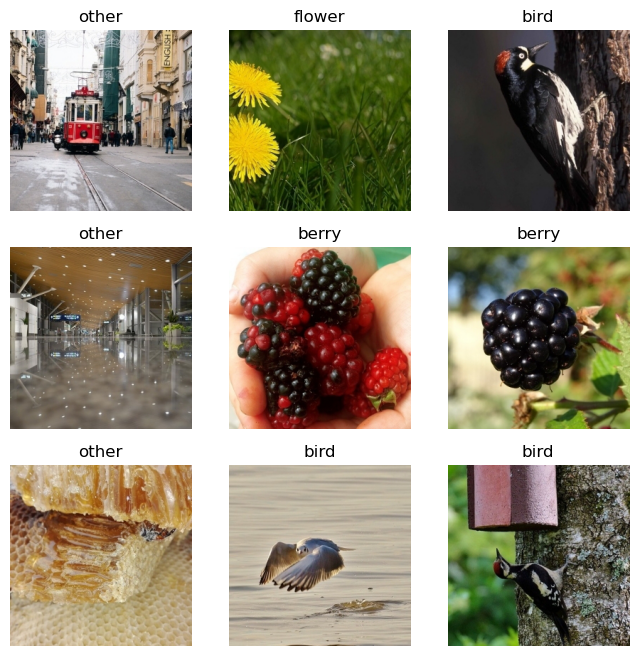

In [49]:
# Visualise the dataset
labels_map = dict(zip(range(len(training_data.categs)), training_data.categs))

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    processed_image = np.rollaxis(img.squeeze().numpy(), 0, 3)
    plt.imshow(processed_image)
plt.show()

In [50]:
# Checking device for cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [51]:
# Datasets
training_data = MyImageDataset("./Linnaeus 5 256X256/train")
test_data = MyImageDataset("./Linnaeus 5 256X256/test")

# DataLoader
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
test_loader = DataLoader(training_data, batch_size=64, shuffle=True)

In [52]:
# Categories
print(training_data.categs)

['berry', 'bird', 'dog', 'flower', 'other']


In [ ]:
# CNN Network
class ConvNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ConvNet, self).__init__()

        # Input Shape = (256, 3, 150, 150)

        # Output size
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()

        # Reduce Image by a size factor of 2
        self.pool = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1
        )
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(
            in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        self.fc = nn.Linear(32 * 75 * 75)